# IMPLEMENTATION: SVM-BASED CLASSIFICATION

*This is an implementation of a classification method with Linear SVM as a part of assginment given in BRI507: INTRODUCTION TO MACHINE LEARNING coursework at Korea University, Seoul, the Republic of Korea. This code is also available at [this page](https://github.com/akhanss/ML-KU).*

In this assignment we:
    
- will implement a SVM-based classification
- no public library is used for SVM training and SVM prediction
- are given three facial expression classes: angry, happy, and surprised
- and 22 features were extracted from an image

In [1]:
# Run some setup code for this notebook.

# library for numerical calculation
import numpy as np

# data analysis library in python
import pandas as pd

# random number generators and get relevant functionalities
import random

# plotting library in python
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Loading Facial Data and Preprocessing

In [2]:
# Load the facial data in a pandas dataframe (df) from excel.
df = pd.read_excel('data/facial_expression_dataset.xlsx')

In [3]:
# showing a few header rows
df.head()

,Class Label,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22
0,1,4.1231,2.8284,6.0828,8.6023,5.0000,3.0000,5.0000,3.6056,8.6023,...,9.0554,8.9443,5.0990,4.1231,11.0454,8.6023,4.1231,14.8661,14.0000,15.2315
1,1,6.3246,5.0000,7.6158,6.0828,4.2426,2.2361,6.4031,4.4721,8.9443,...,12.0416,9.2195,3.6056,13.3417,12.1655,11.4018,4.1231,17.7200,16.0312,19.7231
2,1,5.6569,5.6569,8.5440,5.0000,3.1623,3.0000,10.0000,3.6056,10.2956,...,11.0454,7.0711,7.6158,7.2111,14.3178,8.6023,6.3246,20.5913,17.4642,18.9737
3,1,12.0416,13.3417,8.9443,11.1803,8.4853,6.4031,4.0000,5.8310,6.0828,...,13.3417,9.0000,6.0000,4.1231,1.4142,4.0000,8.9443,10.1980,7.6158,13.0384
4,1,10.0000,14.1421,13.6015,12.0830,9.8995,7.0711,4.4721,9.8489,5.0000,...,8.0000,6.4031,6.0000,7.2801,7.8102,5.3852,8.6023,10.4403,9.2195,13.8924


In [4]:
# Three facial expression classes: angry, happy, and surprised
# Assuming Class Label = 1, 2 and 3 for expression angry, happy, and surprised respectively

class_angry = df[df['Class Label'] == 1]
class_happy = df[df['Class Label'] == 2]
class_surprised = df[df['Class Label'] == 3]

# As a sanity check, we print out the size of the three different classes.
print 'Class Angry: ', class_angry.shape
print 'Class Happy: ', class_happy.shape
print 'Class Surprised: ', class_surprised.shape

Class Angry:  (39, 23)
Class Happy:  (39, 23)
Class Surprised:  (39, 23)


In [5]:
# train and test set split: 80 by 20 for each class, then concatenate all classes.
import math
train_data = []
test_data = []
classes = df['Class Label'].unique()

for aclass in classes:
    class_data = df[df['Class Label'] == aclass]
    nrows, ncols = class_data.shape[0], class_data.shape[1]
    mask = int(math.ceil(nrows * .8))
    train_data.append(np.array(class_data[0:mask-1]))
    test_data.append(class_data[mask:nrows-1])
    
train = np.concatenate(train_data)
test = np.concatenate(test_data)
del class_data, train_data, test_data
print train.shape, test.shape

(93, 23) (18, 23)


In [6]:
# Final train data and label after shuffling
np.random.shuffle(train)
y_train = np.array(train[:, 0]).astype(int)
X_train = train[:, 1:ncols]

# Final test data and label
np.random.shuffle(test)
y_test = np.array(test[:, 0]).astype(int)
X_test = test[:, 1:ncols]

del train, test

# As a sanity check, print out the shapes of the train and test data, and labels
print 'Training data shape: ', X_train.shape
print 'Training label shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test label shape: ', y_test.shape

Training data shape:  (93, 22)
Training label shape:  (93,)
Test data shape:  (18, 22)
Test label shape:  (18,)


In [7]:
# append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print X_train.shape, X_test.shape

(93, 23) (18, 23)


## SVM Classifier

Our code for this section will all be written inside **bri507/classifiers/linear_svm.py**. 

Here, we will evaluate the multiclass SVM loss function. 

In [48]:
# Next implement the function svm_loss; for compute the loss and gradient
from classifiers import svm_loss

# generate a random SVM weight matrix of small numbers
W = np.random.randn(X_train.shape[1], len(classes)) * 0.0001 

# calculating loss and gradient
loss, grad = svm_loss(W, X_train, y_train, classes, 0.00001)
print 'loss: %e' % (loss)

loss: 1.997919e+00


### Stochastic Gradient Descent

We now will do SGD to minimize the loss.

In [41]:
# In the file linear_classifier.py, we've implemented SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers import LinearSVM
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, classes, learning_rate=1e-7, reg=5e4,
                      num_iters=1000, verbose=True)

iteration 0 / 1000: loss 5.796479
iteration 100 / 1000: loss 3.947046
iteration 200 / 1000: loss 3.391112
iteration 300 / 1000: loss 3.060394
iteration 400 / 1000: loss 3.011068
iteration 500 / 1000: loss 2.956806
iteration 600 / 1000: loss 3.012585
iteration 700 / 1000: loss 2.941053
iteration 800 / 1000: loss 2.961289
iteration 900 / 1000: loss 2.892175


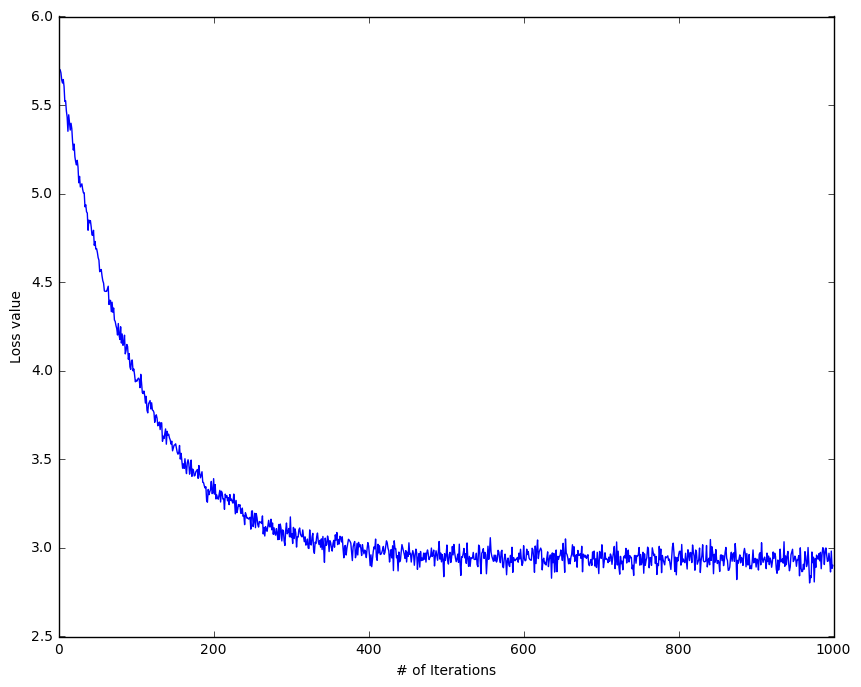

In [42]:
# A useful debugging strategy is to plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('# of Iterations')
plt.ylabel('Loss value')
plt.show()

In [38]:
# Now we'll implement LinearSVM.predict function and evaluate the performance on test set
y_test_pred = svm.predict(X_test)
print 'Test accuracy: %f' % (np.mean(y_test == y_test_pred), )

Test accuracy: 0.333333
